In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import Dataset, DataLoader

from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
from scripts.AutoEncoder import AutoEncoder, AutoEncoderDataset, Encoder, Decoder
from scripts.utils import train_keys, target_keys, ScaleData

In [3]:
train = "/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl"
df_train = pd.read_pickle(train)
df_train = df_train[train_keys]
df_train, scaler = ScaleData(df_train)

df_train.describe()

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
count,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07,2.671596e+07
mean,-7.554751e-17,2.325436e-16,-1.969976e-14,-2.478637e-14,-1.175991e-15,-7.503728e-15,4.034983e-14,-3.315205e-15,-1.910605e-15,4.421118e-16,-5.968948e-16,2.790048e-16,2.490396e-15,1.438155e-14,1.090860e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.249306e+02,-3.814446e+02,-7.457400e+01,-2.143341e+00,-1.921246e+00,-1.297033e+00,-1.710608e+02,-1.277790e+00,-8.474415e+01,-2.678420e+01,-5.509811e+01,-2.109354e+02,-1.799047e+00,-3.488317e+00,-3.060594e+00
25%,-3.258431e-02,-2.497779e-01,-2.199693e-01,-5.673091e-01,-7.880002e-01,-7.826355e-01,1.095864e-04,-7.187233e-01,-5.207354e-01,-3.142720e-01,-1.510736e-01,-1.056034e-01,-2.791258e-01,-1.170805e-01,-7.257788e-01
50%,-1.714946e-02,-1.156905e-01,-2.199693e-01,-5.673091e-01,4.251098e-02,-1.509808e-01,1.095864e-04,-2.630268e-01,-2.760170e-01,-2.158643e-01,-9.455876e-02,-4.192553e-02,-2.264989e-01,-8.693051e-02,-1.606022e-01
75%,5.464286e-03,6.980049e-02,1.017680e-01,3.190794e-01,8.328257e-01,5.075416e-01,1.095864e-04,4.315107e-01,2.244570e-01,6.491163e-02,-1.128275e-02,3.915007e-02,-6.719322e-02,-8.693051e-02,5.922162e-01
max,2.249695e+02,3.585519e+02,5.236406e+01,5.679170e+00,1.572247e+00,1.505446e+01,1.710611e+02,2.417821e+01,2.851771e+02,1.440235e+02,6.117973e+01,2.106058e+02,2.036316e+01,1.787184e+01,8.109160e+00


In [16]:
test = "/share/rcifdata/jbarr/UKAEAGroupProject/data/test_data_clipped.pkl"


df_test = pd.read_pickle(test)
target = df_test['target']
df_test_good = df_test[df_test.target == 1]
df_test_good = df_test[train_keys]

df_test_good,_ = ScaleData(df_test_good, scaler)

df_test_all = df_test[train_keys]
df_test_all,_ = ScaleData(df_test_all, scaler)

n = 10_000
df_test_good.describe()

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
count,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06
mean,1.480916e-04,-9.981783e-04,-4.765438e-04,8.691511e-04,-5.182396e-04,-3.884115e-04,3.116066e-04,-4.423686e-04,-6.358724e-06,-1.101691e-04,1.331482e-03,1.694135e-04,-3.797497e-04,-4.789210e-04,-5.054504e-04
std,8.061888e-01,1.068407e+00,9.926565e-01,1.000534e+00,9.996224e-01,9.995123e-01,8.871090e-01,1.000412e+00,1.016921e+00,9.927253e-01,1.009475e+00,1.043631e+00,9.952746e-01,9.986190e-01,1.000274e+00
min,-2.249306e+02,-3.814446e+02,-7.457400e+01,-2.143341e+00,-1.921246e+00,-1.297033e+00,-1.710608e+02,-1.277790e+00,-8.474415e+01,-2.678420e+01,-5.509811e+01,-2.109354e+02,-1.799047e+00,-3.488317e+00,-3.060594e+00
25%,-3.255359e-02,-2.498094e-01,-2.199693e-01,-5.673091e-01,-7.880403e-01,-7.840538e-01,1.095864e-04,-7.192161e-01,-5.208166e-01,-3.143393e-01,-1.510736e-01,-1.056744e-01,-2.783585e-01,-1.182357e-01,-7.262394e-01
50%,-1.711142e-02,-1.158031e-01,-2.199693e-01,-5.673091e-01,4.248436e-02,-1.518029e-01,1.095864e-04,-2.634447e-01,-2.759386e-01,-2.160454e-01,-9.443357e-02,-4.194699e-02,-2.264526e-01,-8.693051e-02,-1.609747e-01
75%,5.470228e-03,6.947443e-02,1.019715e-01,3.217102e-01,8.318275e-01,5.075416e-01,1.095864e-04,4.306439e-01,2.235747e-01,6.402999e-02,-1.111474e-02,3.896573e-02,-6.671414e-02,-8.693051e-02,5.912568e-01
max,2.249695e+02,3.585519e+02,5.236406e+01,5.679170e+00,1.572247e+00,1.505446e+01,1.710611e+02,2.417821e+01,2.851771e+02,1.440235e+02,6.117973e+01,2.106058e+02,2.036316e+01,1.787184e+01,8.109160e+00


## Model 1 - AE trained on inputs that give outputs

In [6]:
path = glob.glob("/share/rcifdata/jbarr/UKAEAGroupProject/logs/AutoEncoder/Run-13/*")[0]

model = AutoEncoder.load_from_checkpoint(path, n_input = 15, batch_size = 2048, epochs = 150, learning_rate = 0.0025)
encoder = model.encoder

### Evaluate on inputs that give outputs

In [7]:
data_good = torch.from_numpy(df_test_good.values).float()
outputs_good = encoder.forward(data_good).detach().numpy()

<IPython.core.display.Javascript object>


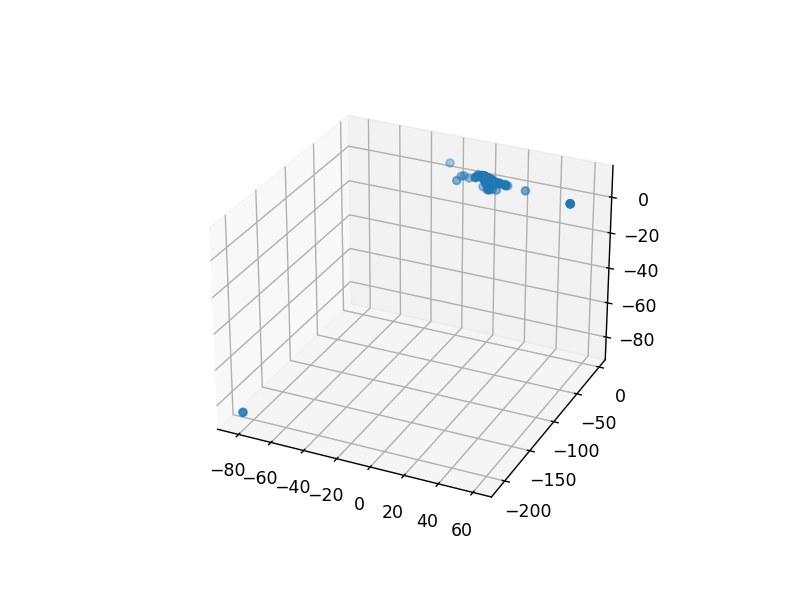

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outputs_good[:n,0], outputs_good[:n,1],outputs_good[:n,2])
fig.show()

<IPython.core.display.Javascript object>


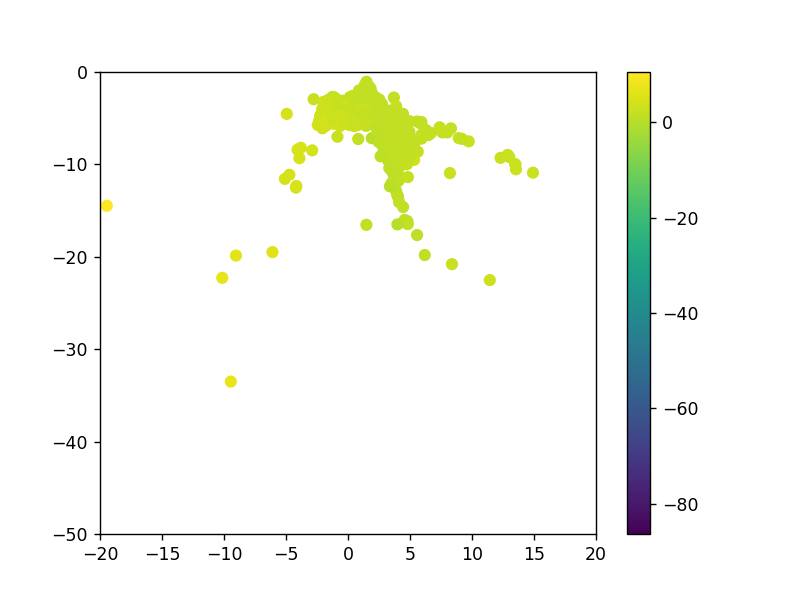

In [12]:
plt.figure()

sc = plt.scatter(outputs_good[:n,0], outputs_good[:n,1], c = outputs_good[:n,2])
plt.xlim(-20,20)
plt.ylim(-50,0)
plt.colorbar(sc)
plt.show()

### Plot  input and output distributions

In [13]:
AE_output = model.forward(data_good).detach().numpy()
df_ae_output = pd.DataFrame(AE_output, columns = train_keys)
df_ae_output['AE'] = 'Outputs'

df_test_tmp = df_test_good
df_test_tmp['AE'] = 'Inputs'

In [14]:
df_compare = pd.concat([df_ae_output, df_test_tmp], ignore_index=True)
df_compare_sample = df_compare.sample(n)

<IPython.core.display.Javascript object>


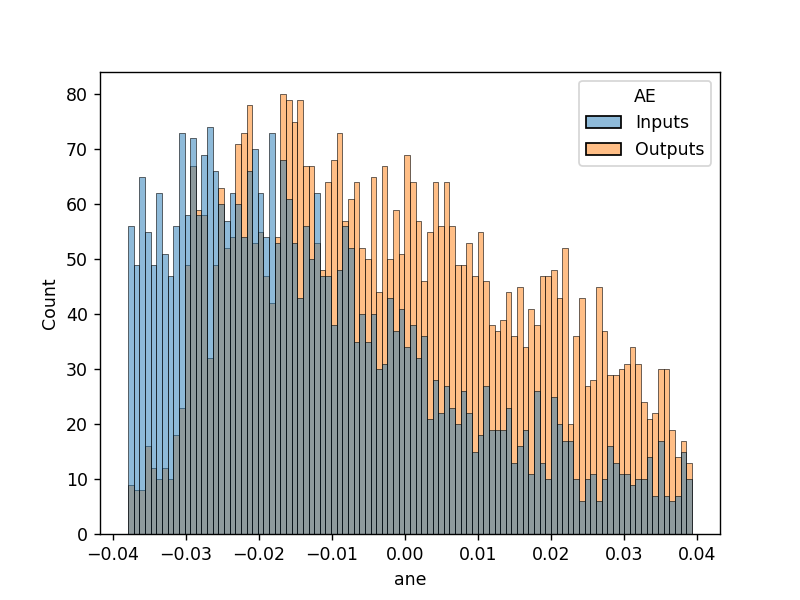

<IPython.core.display.Javascript object>


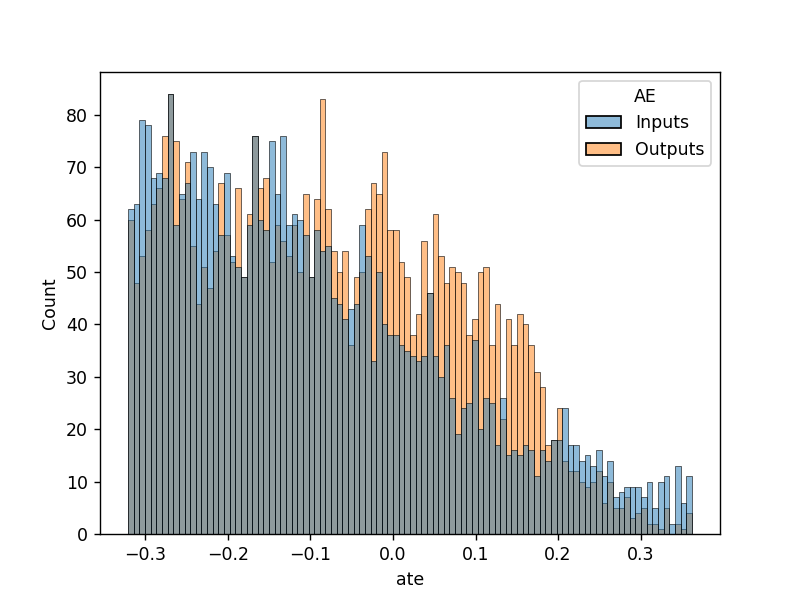

<IPython.core.display.Javascript object>


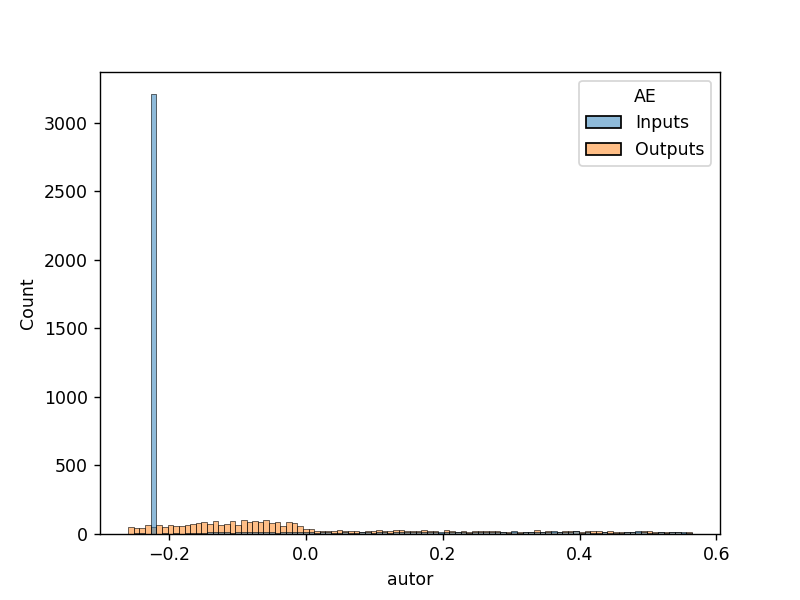

<IPython.core.display.Javascript object>


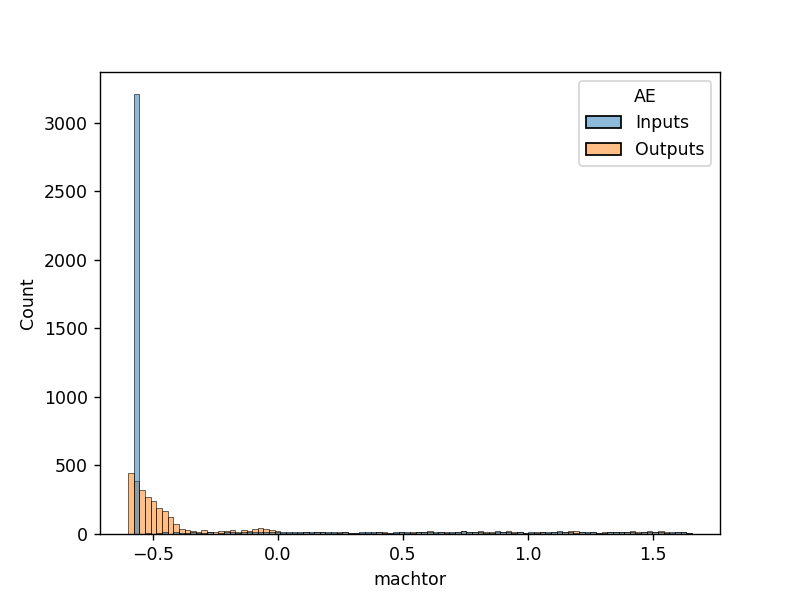

<IPython.core.display.Javascript object>


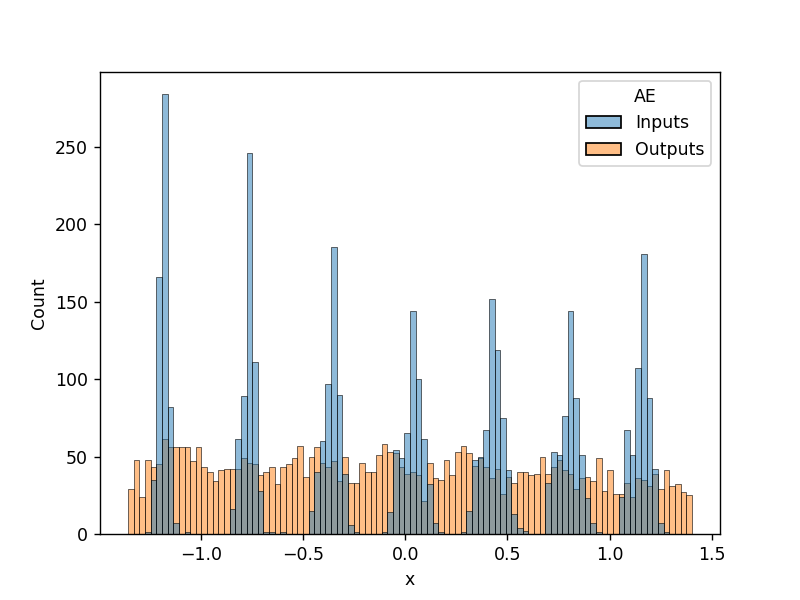

<IPython.core.display.Javascript object>


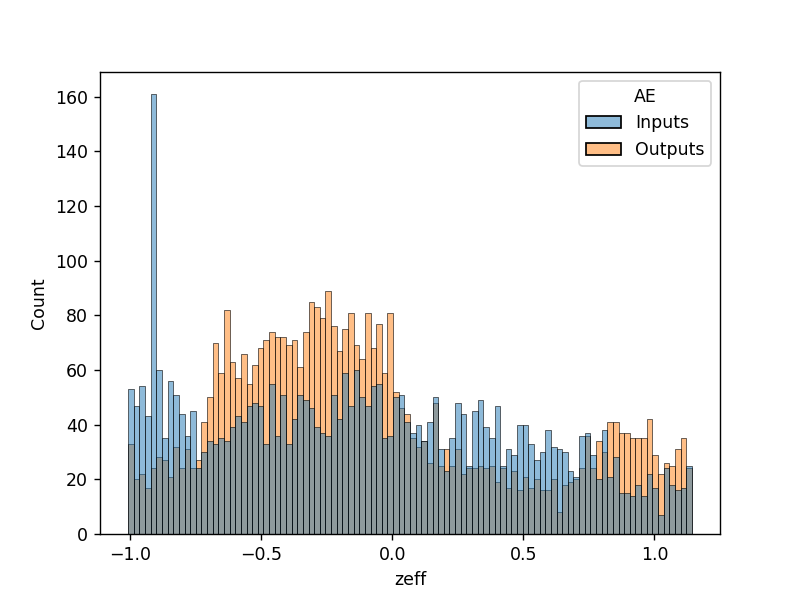

<IPython.core.display.Javascript object>


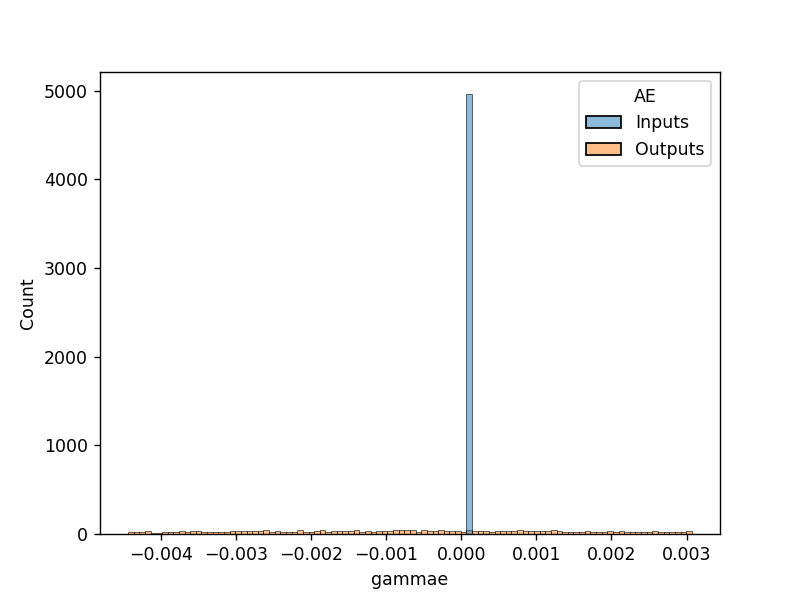

<IPython.core.display.Javascript object>


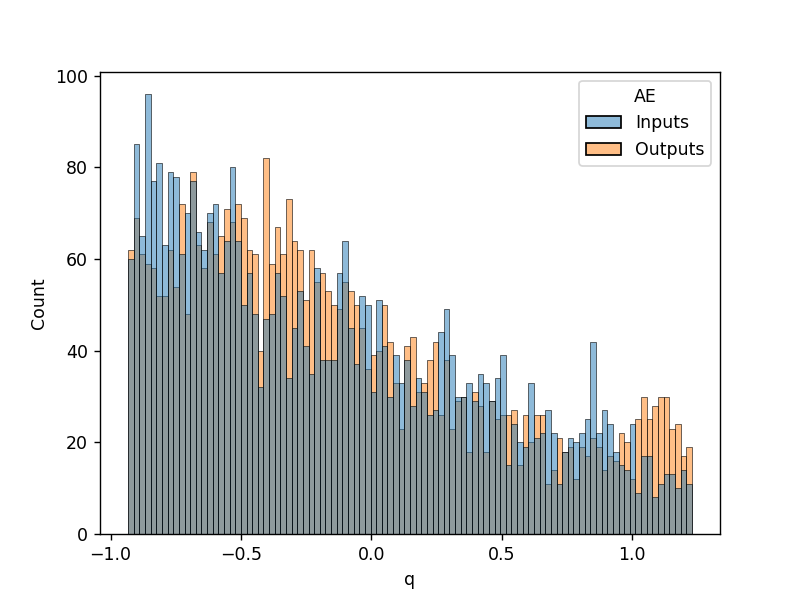

<IPython.core.display.Javascript object>


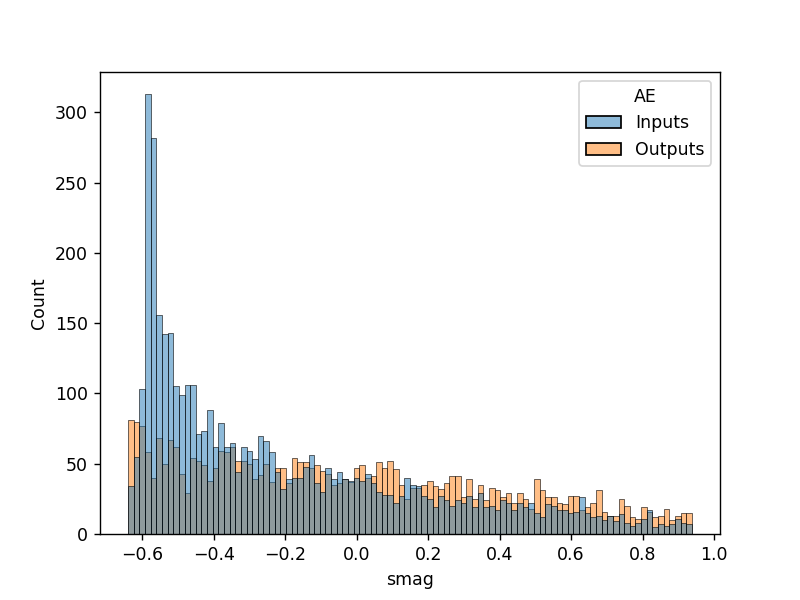

<IPython.core.display.Javascript object>


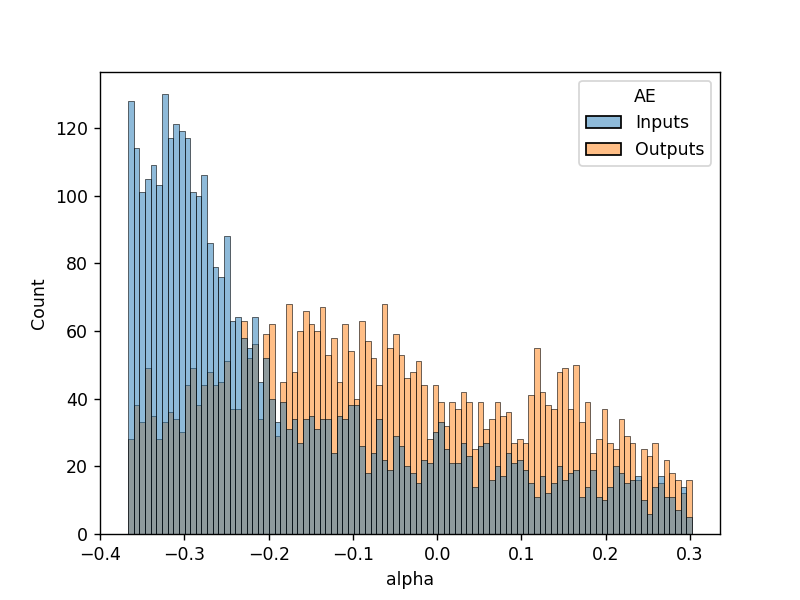

<IPython.core.display.Javascript object>


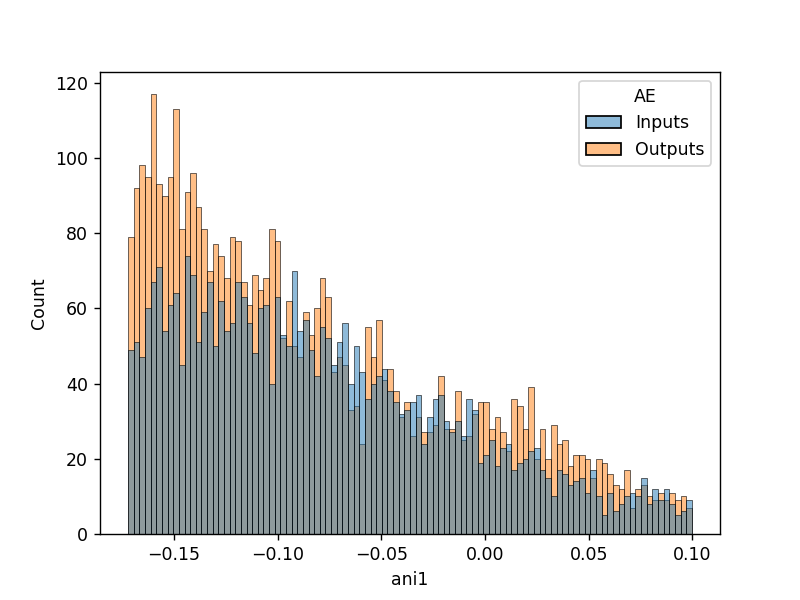

<IPython.core.display.Javascript object>


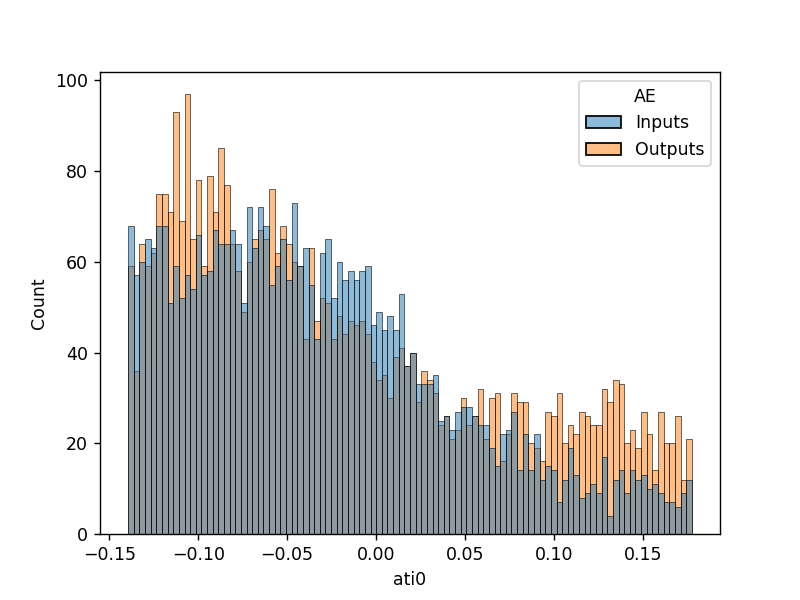

<IPython.core.display.Javascript object>


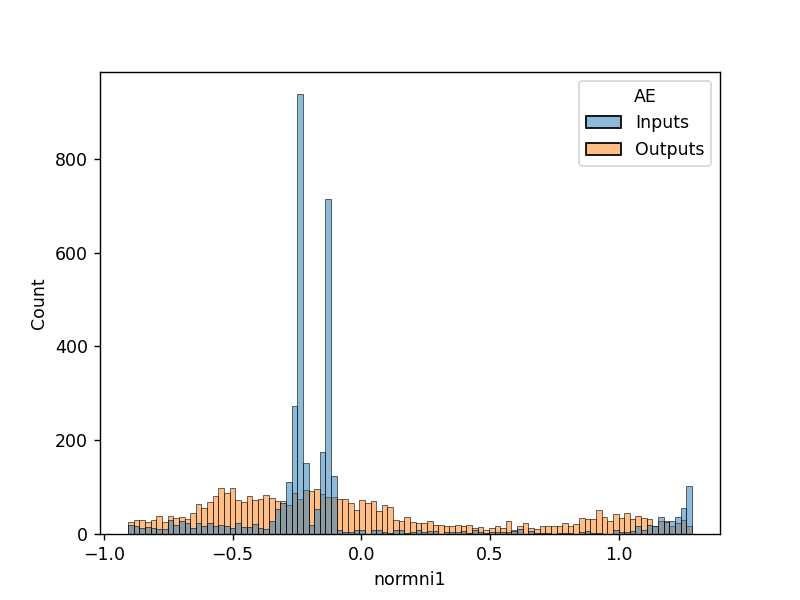

<IPython.core.display.Javascript object>


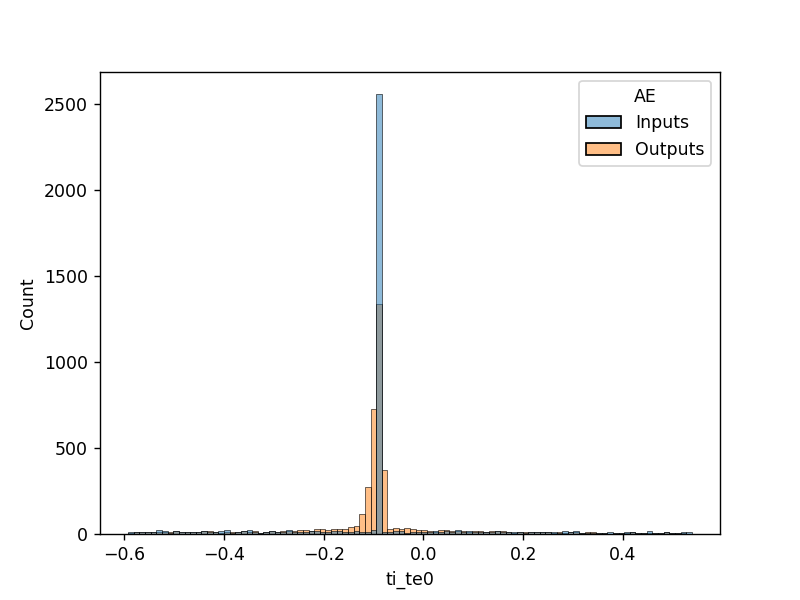

<IPython.core.display.Javascript object>


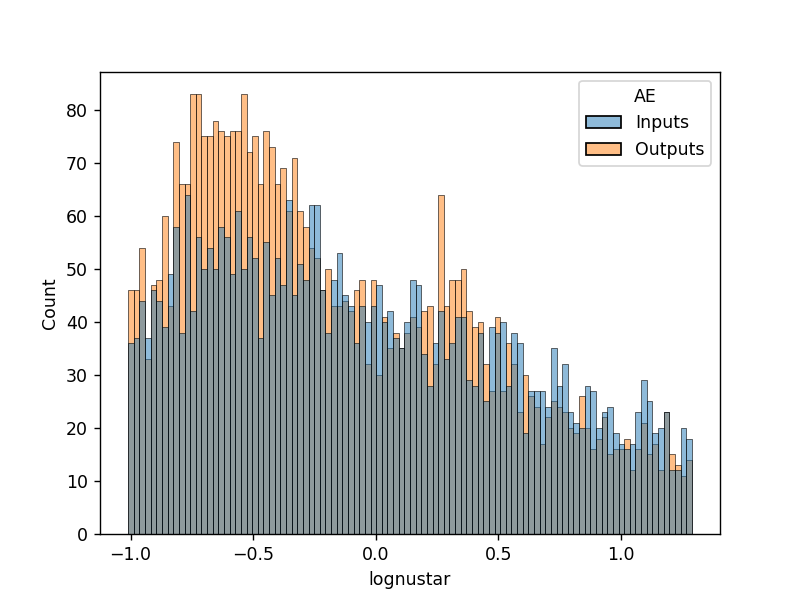

In [15]:
for i in train_keys:
    plt.figure()
    x_min = df_compare_sample[i].quantile(0.1)
    x_max = df_compare_sample[i].quantile(0.9)
    sns.histplot(data = df_compare_sample, x = i, hue = "AE", binrange = (x_min, x_max), bins = 100);
    plt.xlabel(i)

### Evaluate on all inputs

In [17]:
data_test_full = torch.from_numpy(df_test_all.values).float()
outputs_test_full = encoder.forward(data_test_full).detach().numpy()

<IPython.core.display.Javascript object>


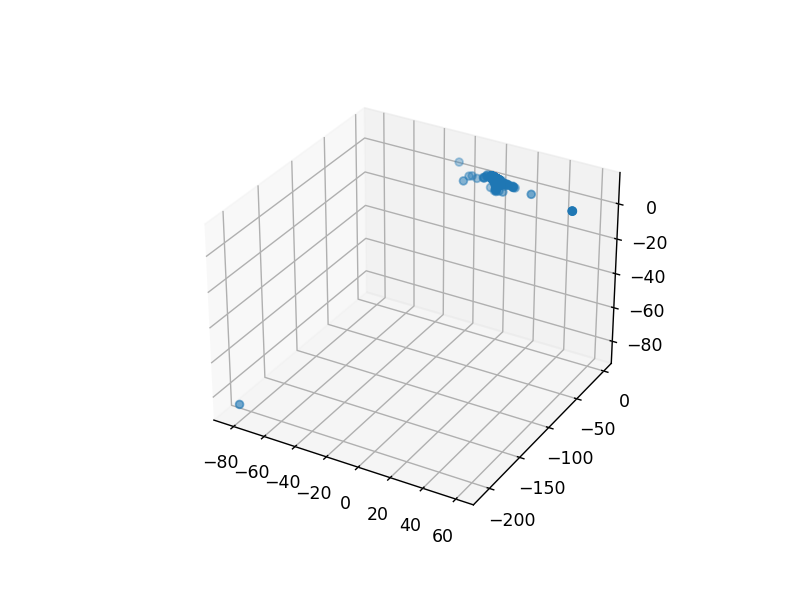

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1],outputs_test_full[:n,2])
fig.show()

<IPython.core.display.Javascript object>


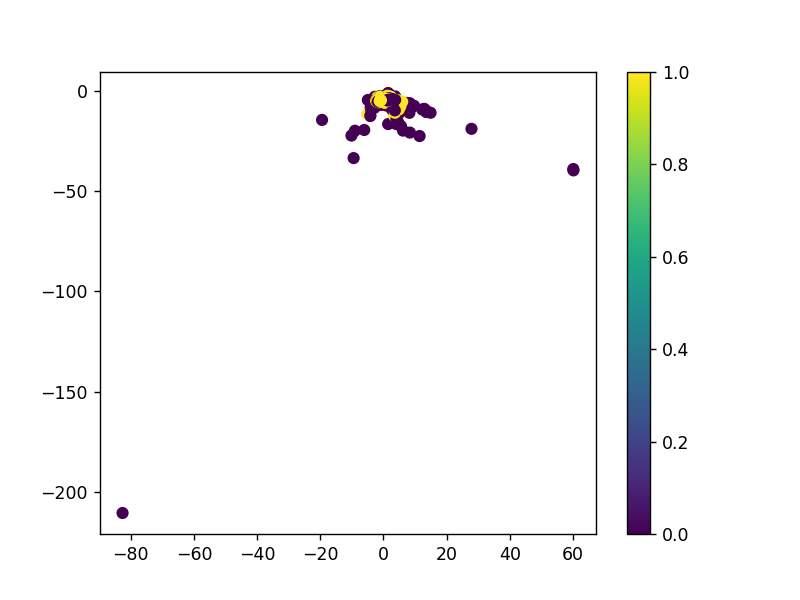

In [21]:
plt.figure()
#sc = plt.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1], c = outputs_test_full[:n,2])
#plt.colorbar(sc)
plt.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1], c = target[:n])
plt.colorbar()

plt.show()

<IPython.core.display.Javascript object>


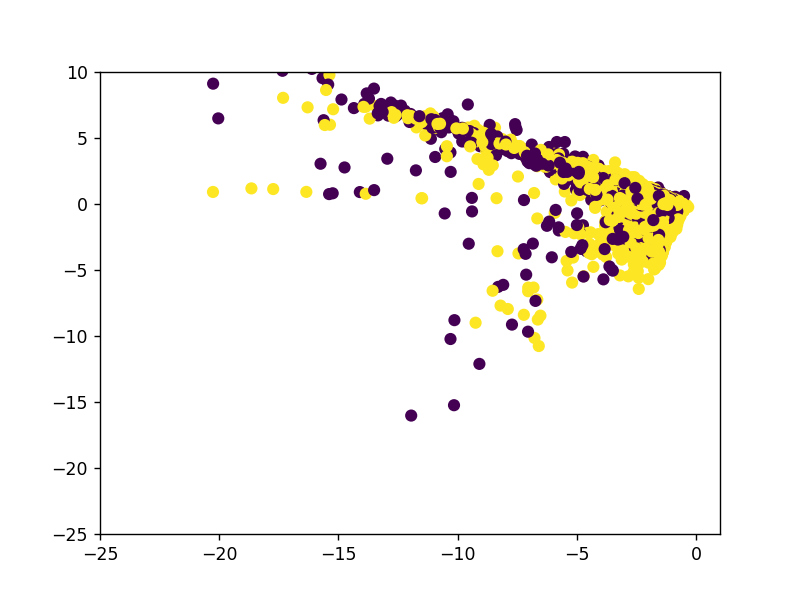

In [18]:
plt.figure()
#sc = plt.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1], c = outputs_test_full[:n,2])
#plt.colorbar(sc)
plt.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1], c =target[:n])
plt.xlim(-25,1)
plt.ylim(-25,10)
plt.show()

In [23]:
outputs_test_full[:n,1].min()

-24566556.0

<IPython.core.display.Javascript object>


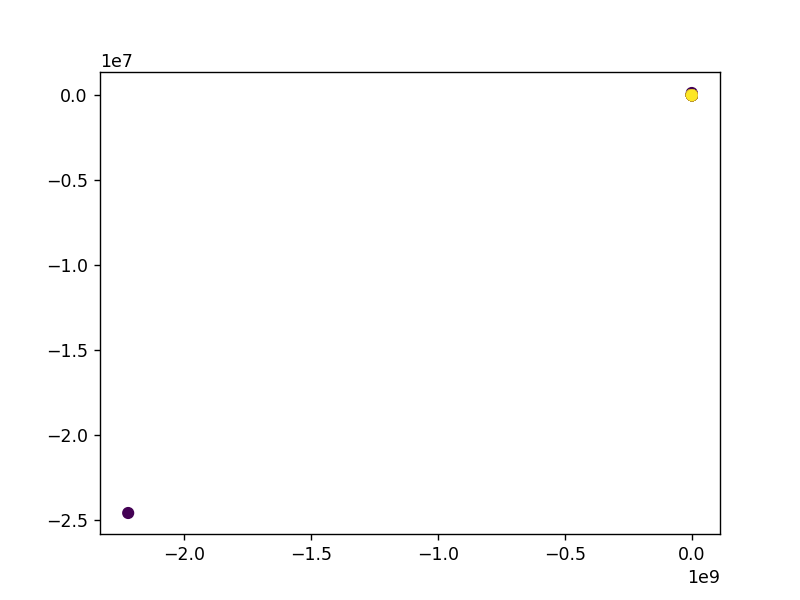

In [27]:
plt.figure()
#sc = plt.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1], c = outputs_test_full[:n,2])
#plt.colorbar(sc)
plt.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1], c =target[:n])
plt.show()

In [42]:
target.shape

(3339495,)

In [43]:
outputs_test_full.shape

(3339495, 3)

In [40]:
idx_left = np.where(outputs_test_full[:,0] < -1.5e9)
idx_right = np.where(outputs_test_full[:,0] > -1.5e9)

data_left = outputs_test_full[idx_left[0]]
targets_left = target[idx_left[0]]
data_right = outputs_test_full[idx_right[0]]
targets_right = target[idx_right[0]]

KeyError: '[4869, 22044, 44585, 226239, 345802, 373775, 405272, 428239, 429597, 434337, 523114, 544315, 596171, 600930, 713854, 782902, 949919, 1056473, 1251270, 1300350, 1388498, 1437497, 1673729, 1730665, 1758429, 1804495, 1825842, 1913540, 2039310, 2150569, 2151426, 2426257, 2478516, 2555026, 2637977, 2654335, 2720329, 2801054, 2803980, 2885797, 2895495, 2930903, 2981620, 3012138, 3015915, 3018684, 3065757, 3113319, 3215403, 3241123] not in index'

In [39]:
idx_left[0]

array([   4869,   22044,   44585,  129819,  135325,  226239,  345802,
        373775,  405272,  428239,  429597,  434337,  523114,  544315,
        596171,  600930,  713854,  782902,  867447,  949919, 1056473,
       1251270, 1300350, 1388498, 1437497, 1673729, 1730665, 1758429,
       1804495, 1825842, 1913540, 1923978, 2039310, 2150569, 2151426,
       2249049, 2426257, 2478516, 2555026, 2637977, 2650468, 2654335,
       2720329, 2801054, 2803980, 2820356, 2885797, 2895495, 2930903,
       2981620, 3012138, 3015915, 3018684, 3065757, 3113319, 3214974,
       3215403, 3241123, 3268321])

In [36]:
outputs_test_full[[0,1,2]]

array([[-1.3052657 ,  0.02925883,  0.96055824],
       [-2.1639023 ,  0.60354245,  1.4047456 ],
       [-1.3148432 ,  0.6713982 ,  1.0025367 ]], dtype=float32)